In [1]:
import os 
import sys
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle as pk
from keras.models import Sequential
from keras.layers import Reshape, Dropout, Dense, Activation, BatchNormalization
from keras.layers import Conv2D, ZeroPadding2D,GlobalAveragePooling2D,Flatten
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import pdb




Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:

iq_data = pk.load(open('/content/gdrive/My Drive/Colab Notebooks/RML2016.10b.dat','rb'),encoding ='latin1')


print('Dataset imported')
#####  from radioML https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb

snrs,modulation = map(lambda j: sorted(list(set(map(lambda x: x[j], iq_data.keys())))), [1,0])


print('Modulation labels: {}'.format(modulation))
print('SNR values for each modulation: {}'.format(snrs))

x_data = []
label = []
for m in modulation:
  for snr in snrs:
    x_data.append(iq_data[(m,snr)])
    for l in np.arange(iq_data[(m,snr)].shape[0]):
      label.append((m,snr))

x_stacked = np.vstack(x_data)

######
print('Dataset shape: {}'.format(x_stacked.shape))



Dataset imported
Modulation labels: ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
SNR values for each modulation: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
Dataset shape: (1200000, 2, 128)


In [4]:

np.random.seed(200)
N_samples = x_stacked.shape[0]

N_train = int(N_samples*0.7)

train_Idx = np.random.choice(np.arange(N_samples),size=N_train,replace=False)

total_N = np.arange(N_samples)

test_Idx = list(set(total_N)-set(train_Idx))

x_train = x_stacked[train_Idx]
x_test = x_stacked[test_Idx]
print(x_train.shape,x_test.shape)

(840000, 2, 128) (360000, 2, 128)


In [7]:
input_encode = lambda x: modulation.index(label[x][0])
y_list_train= np.array(list(map(input_encode,train_Idx)),dtype='float32')
y_list_test = np.array(list(map(input_encode,test_Idx)),dtype='float32')
print(len(y_list_train),len(y_list_test))


840000 360000


In [0]:
y_train = to_categorical(y_list_train,len(modulation))
y_test = to_categorical(y_list_test,len(modulation))


In [9]:
print('Number of Samples, height, width')
print(x_train.shape)


N,H,W = x_train.shape
N_test = x_test.shape[0]
C = 1

x_train = x_train.reshape(N,H,W,C)
x_test  = x_test.reshape(N_test,H,W,C)
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)


Number of Samples, height, width
(840000, 2, 128)
(840000, 2, 128, 1) (360000, 2, 128, 1)
(840000, 10) (360000, 10)


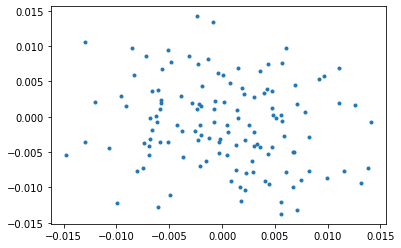

In [9]:
plt.plot(x_train[0,0,:],x_train[0,1,:],'.')

In [14]:
# CNN
model = Sequential(name='CNN_Architecture')

model.add(ZeroPadding2D((0,2),data_format='channels_last'))

model.add(Conv2D(64,(2,3),activation= 'relu',data_format='channels_last',input_shape= (H,W,C),name = 'conv1'))
model.add(Dropout(0.5))
model.add(Conv2D(80,(1,3),activation= 'relu',data_format='channels_last'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(len(modulation),activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.build(input_shape = (None,H,W,C))
model.summary()


Model: "CNN_Architecture"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_3 (ZeroPaddin (None, 2, 132, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 130, 64)        448       
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 130, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 128, 80)        15440     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 128, 80)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10240)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)          

In [0]:
epoch = 50
batch = 1024
checkpoint = ModelCheckpoint("/content/gdrive/My Drive/Colab Notebooks/CNN_weights.best.hdf5", monitor='loss',
    save_best_only=True, mode='auto')


start_run =model.fit(x_train,y_train,batch_size=batch,epochs=epoch,verbose=2,validation_data=(x_test,y_test)) #, callbacks=[checkpoint]

Train on 840000 samples, validate on 360000 samples
Epoch 1/50
 - 31s - loss: 1.7859 - acc: 0.2949 - val_loss: 1.4997 - val_acc: 0.4012
Epoch 2/50
 - 30s - loss: 1.4093 - acc: 0.4335 - val_loss: 1.3570 - val_acc: 0.4377
Epoch 3/50
 - 30s - loss: 1.3055 - acc: 0.4677 - val_loss: 1.2802 - val_acc: 0.4735
Epoch 4/50
 - 30s - loss: 1.2597 - acc: 0.4822 - val_loss: 1.2360 - val_acc: 0.4898
Epoch 5/50
 - 30s - loss: 1.2212 - acc: 0.4965 - val_loss: 1.2057 - val_acc: 0.5016
Epoch 6/50
 - 30s - loss: 1.1931 - acc: 0.5082 - val_loss: 1.1686 - val_acc: 0.5199
Epoch 7/50
 - 30s - loss: 1.1761 - acc: 0.5142 - val_loss: 1.1925 - val_acc: 0.5107
Epoch 8/50
 - 30s - loss: 1.1661 - acc: 0.5169 - val_loss: 1.1769 - val_acc: 0.5146
Epoch 9/50


In [0]:
import matplotlib.pyplot as plt

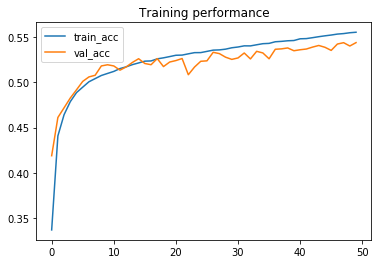

In [14]:
plt.figure()
plt.title('Training performance')
plt.plot(start_run.epoch, start_run.history['acc'], label='train_acc')
plt.plot(start_run.epoch, start_run.history['val_acc'], label='val_acc')
plt.legend()

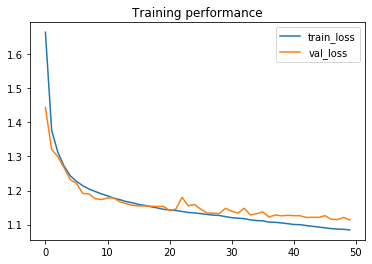

In [15]:
plt.figure()
plt.title('Training performance')
plt.plot(start_run.epoch, start_run.history['loss'], label='train_loss')
plt.plot(start_run.epoch, start_run.history['val_loss'], label='val_loss')
plt.legend()

In [0]:
from sklearn.metrics import confusion_matrix
model.load_weights("/content/gdrive/My Drive/Colab Notebooks/CNN_weights.best.hdf5")


In [32]:
batch = 1024
y_pred = model.predict(x_test,batch)
score = model.evaluate(x_test, y_test, verbose=0, batch_size=batch)
print(score)

[1.0172146994267486, 0.5721]


In [0]:

y_pred_label = model.predict_classes(x_test,batch)
y_test_label = np.argmax(y_test,axis=1)

cm = confusion_matrix(y_test_label,y_pred_label, normalize= 'true')


In [0]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test_label,y_pred_label)
fg, ax = plot_confusion_matrix(cm,colorbar=True,
                                show_absolute=False,
                                show_normed=True)


ax.set_xticks(np.arange(len(modulation)))
ax.set_xticklabels(modulation, rotation = 45)
ax.set_title("CNN Confusion Matrix")
ax.set_yticks(np.arange(len(modulation)))
ax.set_yticklabels(modulation)

fg.set_size_inches(16.5, 8.5, forward=True)
